In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *
from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-05-28 01:01:36.867610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 01:01:36.867664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 01:01:36.998432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 01:01:37.166168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    # strategy = tf.distribute.MirroredStrategy()
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Tue May 28 01:02:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:01:00.0 Off |                    0 |
| N/A   29C    P0              41W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   3  NVIDIA A100 80GB PCIe          Off | 00000000:81:00.0 Off |                    0 |
| N/A   46C    P0             271W / 300W |    827MiB / 81920MiB |     90%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   4  NVIDIA A100 80GB PCIe          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   27C    P0              42W / 300W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   5  NVIDIA A100 80GB PCIe          Off | 00000000:E1:00.0 Off |                    0 |
| N/A   27C    P0              42W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
img_url = '../thebe_new/seismic'
target_url = '../thebe_new/fault'
seis = Thebe(img_url, target_url)
    
# Create datasets for respective data samples and labels
train_dataset = seis.data_generator('train', batch_size=BATCH_SIZE, cache=NUM_GPU) 
val_dataset = seis.data_generator('val', batch_size=BATCH_SIZE, cache=NUM_GPU)
x_test, y_test = seis.data_generator('test', as_numpy=True)
        
print("Train Dataset:", train_dataset)

print("Size of training data: {}".format(seis.train_size))
print("Size of validation data: {}".format(seis.validation_size))
print("Size of test data: {}".format(seis.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


2024-05-28 01:02:38.491062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:41:00.0, compute capability: 8.0


Train Dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None))>
Size of training data: 181029
Size of validation data: 64317
Size of test data: 66077
...elapsed time: ___ 0.86 minutes___


2024-05-28 01:03:26.642684: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


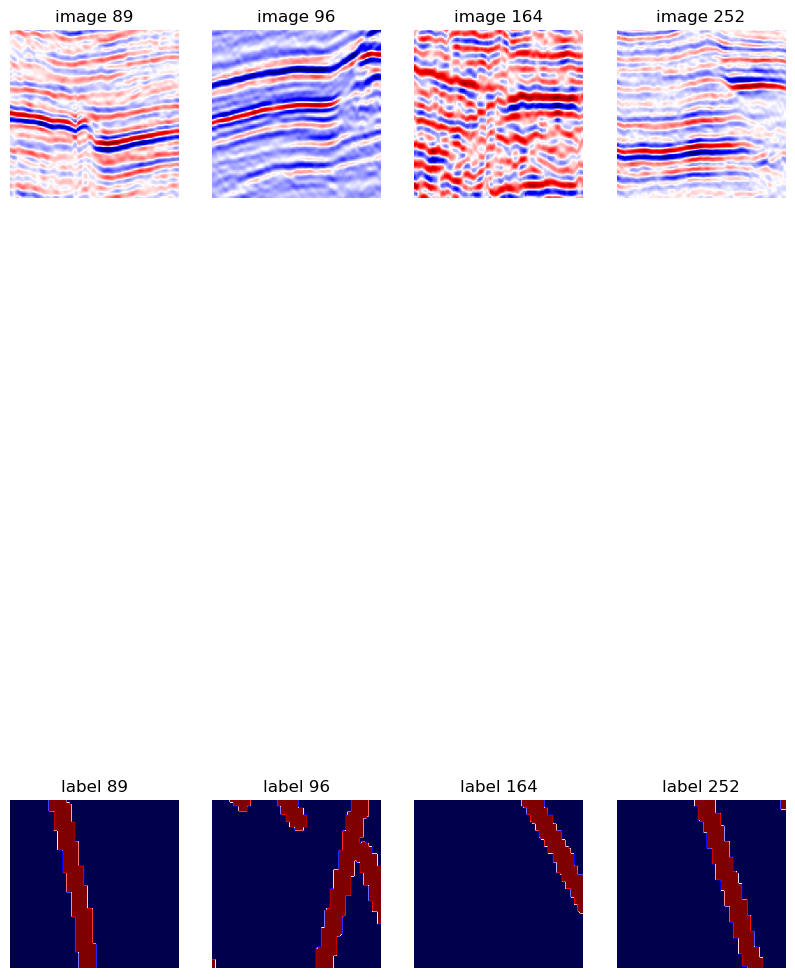

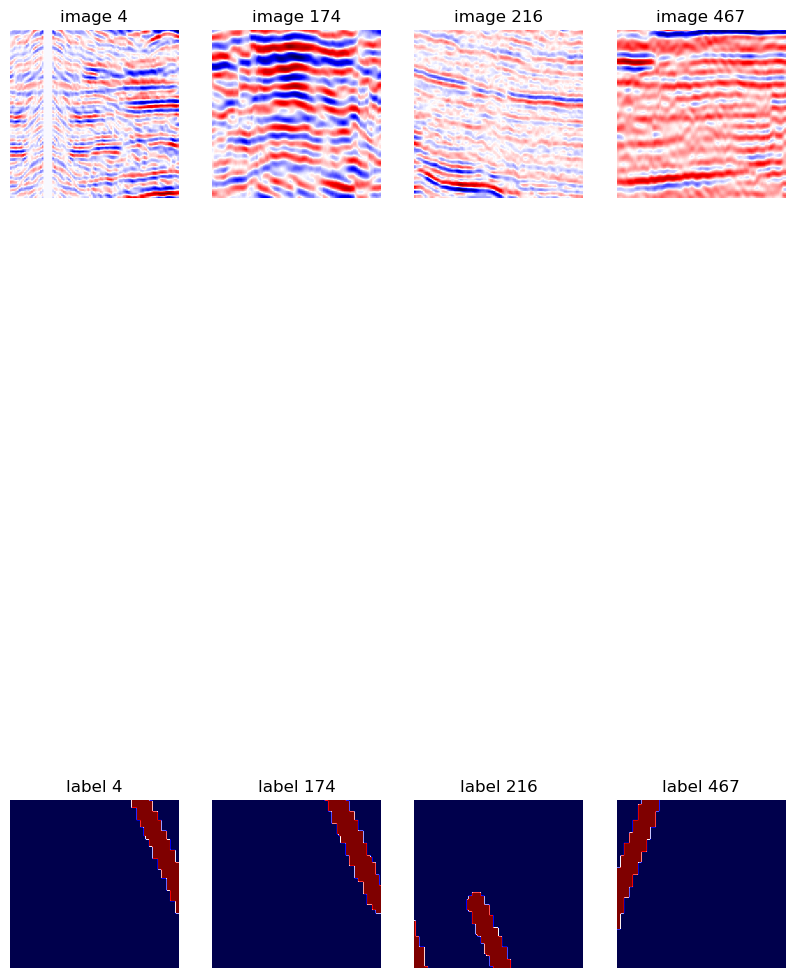

In [7]:
if INTERACTIVE_SESSION:
    X, y = next(train_dataset.as_numpy_iterator())
    # X, y = next(val_dataset.as_numpy_iterator())
    seis.display_sample_images(X, y, num_images=4)
    seis.display_sample_images(X, y, num_images=4)

    # seis.display_sample_images(x_test, y_test, num_images=4)
    # seis.display_sample_images(x_test, y_test, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/fnet',
    img_shape=seis.img_size,
    target_size=seis.img_size,
    threshold=seis.threshold,
    pos_label=seis.pos_label,
    train_size=seis.train_size,
    test_size=seis.test_size,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=seis.validation_size
)

callbacks = conf.callbacks(
    chkpt_monitor='val_f1_score', 
    es_monitor='val_loss',
    es_patience=100, 
    lr_monitor='val_loss',
)

conf.set( validation_data=val_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=seis.pos_label, threshold=seis.threshold)
conf.set(
    'compile', metrics= ['accuracy', m1]
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/fnet
           test_size: 66077
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
               validation_data: <class 'tensorflow.python.data.ops.cache_op.CacheDataset'>
                 

### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    # strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        conf = model_config(
            epochs=100,
            batch_size=BATCH_SIZE,
            shuffle=True,
            scaling=1,
            save_path='./Thebe/fnet',
            img_shape=seis.img_size,
            target_size=seis.img_size,
            threshold=seis.threshold,
            pos_label=seis.pos_label,
            train_size=seis.train_size,
            test_size=seis.test_size,
            new_training_session=True,
            multiple_gpu_device=(NUM_GPU>1),
            validation_size=seis.validation_size
        )

        callbacks = conf.callbacks(
            chkpt_monitor='val_f1_score', 
            es_monitor='val_loss',
            es_patience=100, 
            lr_monitor='val_loss',
        )

        conf.set( validation_data=val_dataset,  callbacks=callbacks )
        m1 = f1_score(positive_label=seis.pos_label, threshold=seis.threshold)
        conf.set(
            'compile',
            metrics= ['accuracy', m1]
        )

        # m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    # m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 6,824,641
Total trainable wieghts: 6,815,297
Total non-trainable wieghts: 9,344


### Train  model



	Train fnet model
-------------------------------------------------------
Model training...


2024-05-28 01:03:54.679129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inF-NET/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-28 01:03:56.183622: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-28 01:04:15.937485: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f467c9487a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-28 01:04:15.937534: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-05-28 01:04:15.991589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1716851056.283487  989925 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 44: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 54: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 64: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 74: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.



Epoch 84: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.



Epoch 94: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.


training elapsed time: ___423.55___ minutes
...training completed!


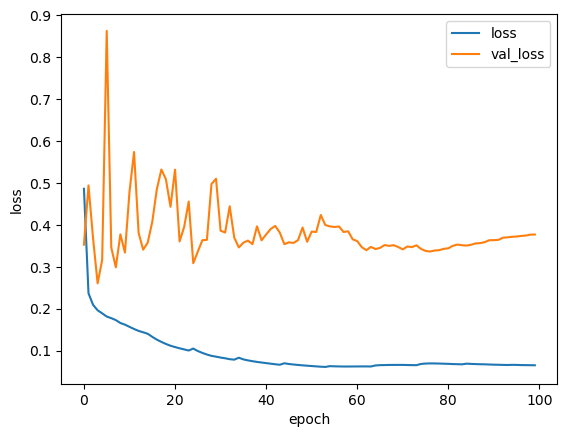

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)


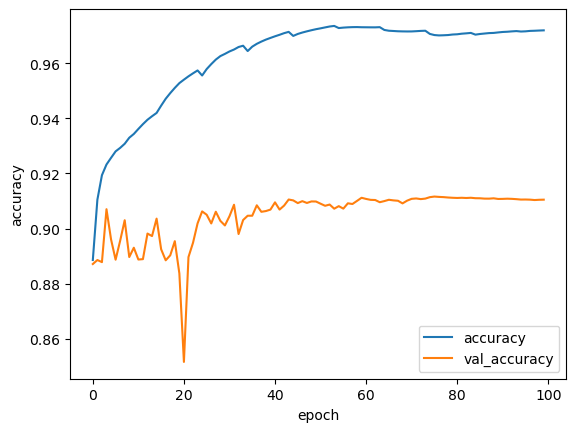

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

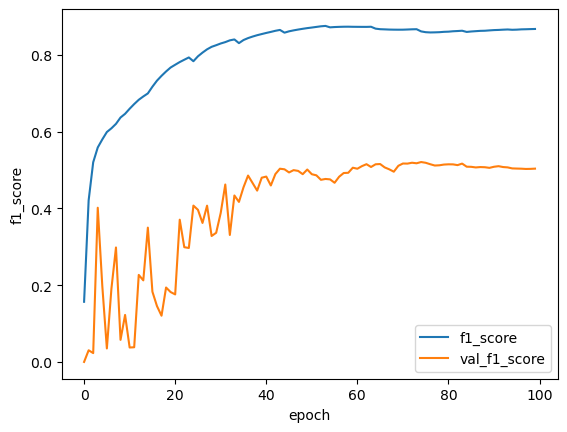

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

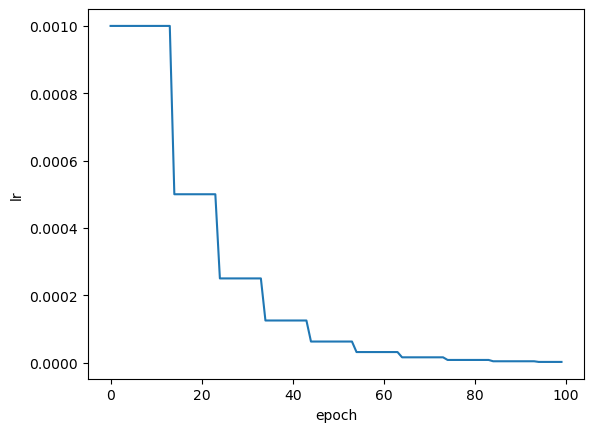

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
y_pred = model.predict(x_test)




	Evaluate fnet model
-------------------------------------------------------


   1/2065 [..............................] - ETA: 1:03:30

   6/2065 [..............................] - ETA: 23s    

  10/2065 [..............................] - ETA: 25s

  14/2065 [..............................] - ETA: 25s

  18/2065 [..............................] - ETA: 25s

  22/2065 [..............................] - ETA: 25s

  26/2065 [..............................] - ETA: 25s

  30/2065 [..............................] - ETA: 25s

  34/2065 [..............................] - ETA: 25s

  38/2065 [..............................] - ETA: 25s

  42/2065 [..............................] - ETA: 25s

  46/2065 [..............................] - ETA: 25s

  50/2065 [..............................] - ETA: 25s

  54/2065 [..............................] - ETA: 25s

  58/2065 [..............................] - ETA: 25s

  62/2065 [..............................] - ETA: 25s

  66/2065 [..............................] - ETA: 25s

  70/2065 [>.............................] - ETA: 25s

  74/2065 [>.............................] - ETA: 25s

  78/2065 [>.............................] - ETA: 25s

  82/2065 [>.............................] - ETA: 25s

  86/2065 [>.............................] - ETA: 25s

  90/2065 [>.............................] - ETA: 25s

  94/2065 [>.............................] - ETA: 25s

  98/2065 [>.............................] - ETA: 25s

 102/2065 [>.............................] - ETA: 25s

 106/2065 [>.............................] - ETA: 25s

 110/2065 [>.............................] - ETA: 25s

 114/2065 [>.............................] - ETA: 24s

 118/2065 [>.............................] - ETA: 24s

 122/2065 [>.............................] - ETA: 24s

 126/2065 [>.............................] - ETA: 24s

 130/2065 [>.............................] - ETA: 24s

 134/2065 [>.............................] - ETA: 24s

 138/2065 [=>............................] - ETA: 24s

 142/2065 [=>............................] - ETA: 24s

 146/2065 [=>............................] - ETA: 24s

 150/2065 [=>............................] - ETA: 24s

 154/2065 [=>............................] - ETA: 24s

 158/2065 [=>............................] - ETA: 24s

 162/2065 [=>............................] - ETA: 24s

 166/2065 [=>............................] - ETA: 24s

 170/2065 [=>............................] - ETA: 24s

 174/2065 [=>............................] - ETA: 24s

 178/2065 [=>............................] - ETA: 24s

 182/2065 [=>............................] - ETA: 24s

 186/2065 [=>............................] - ETA: 24s

 190/2065 [=>............................] - ETA: 24s

 194/2065 [=>............................] - ETA: 23s

 198/2065 [=>............................] - ETA: 23s

 202/2065 [=>............................] - ETA: 23s

 206/2065 [=>............................] - ETA: 23s

 210/2065 [==>...........................] - ETA: 23s

 214/2065 [==>...........................] - ETA: 23s

 218/2065 [==>...........................] - ETA: 23s

 222/2065 [==>...........................] - ETA: 23s

 226/2065 [==>...........................] - ETA: 23s

 230/2065 [==>...........................] - ETA: 23s

 234/2065 [==>...........................] - ETA: 23s

 238/2065 [==>...........................] - ETA: 23s

 242/2065 [==>...........................] - ETA: 23s

 246/2065 [==>...........................] - ETA: 23s

 250/2065 [==>...........................] - ETA: 23s

 254/2065 [==>...........................] - ETA: 23s

 258/2065 [==>...........................] - ETA: 23s

 262/2065 [==>...........................] - ETA: 23s

 266/2065 [==>...........................] - ETA: 23s

 270/2065 [==>...........................] - ETA: 23s

 274/2065 [==>...........................] - ETA: 22s

 278/2065 [===>..........................] - ETA: 22s

 282/2065 [===>..........................] - ETA: 22s

 286/2065 [===>..........................] - ETA: 22s

 290/2065 [===>..........................] - ETA: 22s

 294/2065 [===>..........................] - ETA: 22s

 298/2065 [===>..........................] - ETA: 22s

 302/2065 [===>..........................] - ETA: 22s

 306/2065 [===>..........................] - ETA: 22s

 310/2065 [===>..........................] - ETA: 22s

 314/2065 [===>..........................] - ETA: 22s

 318/2065 [===>..........................] - ETA: 22s

 322/2065 [===>..........................] - ETA: 22s

 326/2065 [===>..........................] - ETA: 22s

 330/2065 [===>..........................] - ETA: 22s

 334/2065 [===>..........................] - ETA: 22s

 338/2065 [===>..........................] - ETA: 22s

 342/2065 [===>..........................] - ETA: 22s

 346/2065 [====>.........................] - ETA: 22s

 350/2065 [====>.........................] - ETA: 22s

 354/2065 [====>.........................] - ETA: 21s

 358/2065 [====>.........................] - ETA: 21s

 362/2065 [====>.........................] - ETA: 21s

 366/2065 [====>.........................] - ETA: 21s

 370/2065 [====>.........................] - ETA: 21s

 374/2065 [====>.........................] - ETA: 21s

 378/2065 [====>.........................] - ETA: 21s

 382/2065 [====>.........................] - ETA: 21s

 386/2065 [====>.........................] - ETA: 21s

 390/2065 [====>.........................] - ETA: 21s

 394/2065 [====>.........................] - ETA: 21s

 398/2065 [====>.........................] - ETA: 21s

 402/2065 [====>.........................] - ETA: 21s

 406/2065 [====>.........................] - ETA: 21s

 410/2065 [====>.........................] - ETA: 21s

 414/2065 [=====>........................] - ETA: 21s

 418/2065 [=====>........................] - ETA: 21s

 422/2065 [=====>........................] - ETA: 21s

 426/2065 [=====>........................] - ETA: 21s

 430/2065 [=====>........................] - ETA: 20s

 434/2065 [=====>........................] - ETA: 20s

 438/2065 [=====>........................] - ETA: 20s

 442/2065 [=====>........................] - ETA: 20s

 446/2065 [=====>........................] - ETA: 20s

 450/2065 [=====>........................] - ETA: 20s

 454/2065 [=====>........................] - ETA: 20s

 458/2065 [=====>........................] - ETA: 20s

 462/2065 [=====>........................] - ETA: 20s

 466/2065 [=====>........................] - ETA: 20s

 470/2065 [=====>........................] - ETA: 20s

 474/2065 [=====>........................] - ETA: 20s

 478/2065 [=====>........................] - ETA: 20s

 482/2065 [======>.......................] - ETA: 20s

 486/2065 [======>.......................] - ETA: 20s

 490/2065 [======>.......................] - ETA: 20s

 494/2065 [======>.......................] - ETA: 20s

 498/2065 [======>.......................] - ETA: 20s

 502/2065 [======>.......................] - ETA: 20s

 506/2065 [======>.......................] - ETA: 20s

 510/2065 [======>.......................] - ETA: 19s

 515/2065 [======>.......................] - ETA: 19s

 519/2065 [======>.......................] - ETA: 19s

 523/2065 [======>.......................] - ETA: 19s

 527/2065 [======>.......................] - ETA: 19s

 531/2065 [======>.......................] - ETA: 19s

 535/2065 [======>.......................] - ETA: 19s

 539/2065 [======>.......................] - ETA: 19s

 543/2065 [======>.......................] - ETA: 19s

 547/2065 [======>.......................] - ETA: 19s

 551/2065 [=======>......................] - ETA: 19s

 555/2065 [=======>......................] - ETA: 19s

 559/2065 [=======>......................] - ETA: 19s

 563/2065 [=======>......................] - ETA: 19s

 567/2065 [=======>......................] - ETA: 19s

 571/2065 [=======>......................] - ETA: 19s

 575/2065 [=======>......................] - ETA: 19s

 579/2065 [=======>......................] - ETA: 19s

 583/2065 [=======>......................] - ETA: 19s

 587/2065 [=======>......................] - ETA: 18s

 591/2065 [=======>......................] - ETA: 18s

 595/2065 [=======>......................] - ETA: 18s

 599/2065 [=======>......................] - ETA: 18s

 603/2065 [=======>......................] - ETA: 18s

 607/2065 [=======>......................] - ETA: 18s

 611/2065 [=======>......................] - ETA: 18s

 615/2065 [=======>......................] - ETA: 18s

 619/2065 [=======>......................] - ETA: 18s

 623/2065 [========>.....................] - ETA: 18s

 627/2065 [========>.....................] - ETA: 18s

 631/2065 [========>.....................] - ETA: 18s

 635/2065 [========>.....................] - ETA: 18s

 639/2065 [========>.....................] - ETA: 18s

 643/2065 [========>.....................] - ETA: 18s

 647/2065 [========>.....................] - ETA: 18s

 651/2065 [========>.....................] - ETA: 18s

 655/2065 [========>.....................] - ETA: 18s

 659/2065 [========>.....................] - ETA: 18s

 663/2065 [========>.....................] - ETA: 17s

 667/2065 [========>.....................] - ETA: 17s

 671/2065 [========>.....................] - ETA: 17s

 675/2065 [========>.....................] - ETA: 17s

 679/2065 [========>.....................] - ETA: 17s

 683/2065 [========>.....................] - ETA: 17s

 687/2065 [========>.....................] - ETA: 17s

 691/2065 [=========>....................] - ETA: 17s

 695/2065 [=========>....................] - ETA: 17s

 699/2065 [=========>....................] - ETA: 17s

 703/2065 [=========>....................] - ETA: 17s

 707/2065 [=========>....................] - ETA: 17s

 711/2065 [=========>....................] - ETA: 17s

 715/2065 [=========>....................] - ETA: 17s

 719/2065 [=========>....................] - ETA: 17s

 723/2065 [=========>....................] - ETA: 17s

 727/2065 [=========>....................] - ETA: 17s

 731/2065 [=========>....................] - ETA: 17s

 735/2065 [=========>....................] - ETA: 17s

 739/2065 [=========>....................] - ETA: 17s

 743/2065 [=========>....................] - ETA: 16s

 747/2065 [=========>....................] - ETA: 16s

 751/2065 [=========>....................] - ETA: 16s

 755/2065 [=========>....................] - ETA: 16s

 759/2065 [==========>...................] - ETA: 16s

 763/2065 [==========>...................] - ETA: 16s

 767/2065 [==========>...................] - ETA: 16s

 771/2065 [==========>...................] - ETA: 16s

 775/2065 [==========>...................] - ETA: 16s

 779/2065 [==========>...................] - ETA: 16s

 783/2065 [==========>...................] - ETA: 16s

 787/2065 [==========>...................] - ETA: 16s

 791/2065 [==========>...................] - ETA: 16s

 795/2065 [==========>...................] - ETA: 16s

 799/2065 [==========>...................] - ETA: 16s

 803/2065 [==========>...................] - ETA: 16s

 807/2065 [==========>...................] - ETA: 16s

 811/2065 [==========>...................] - ETA: 16s

 815/2065 [==========>...................] - ETA: 16s

 819/2065 [==========>...................] - ETA: 15s

 823/2065 [==========>...................] - ETA: 15s

 827/2065 [===========>..................] - ETA: 15s

 831/2065 [===========>..................] - ETA: 15s

 835/2065 [===========>..................] - ETA: 15s

 839/2065 [===========>..................] - ETA: 15s

 843/2065 [===========>..................] - ETA: 15s

 847/2065 [===========>..................] - ETA: 15s

 851/2065 [===========>..................] - ETA: 15s

 855/2065 [===========>..................] - ETA: 15s

 859/2065 [===========>..................] - ETA: 15s

 863/2065 [===========>..................] - ETA: 15s

 867/2065 [===========>..................] - ETA: 15s

 871/2065 [===========>..................] - ETA: 15s

 875/2065 [===========>..................] - ETA: 15s

 879/2065 [===========>..................] - ETA: 15s

 884/2065 [===========>..................] - ETA: 15s

 888/2065 [===========>..................] - ETA: 15s

 892/2065 [===========>..................] - ETA: 15s

 896/2065 [============>.................] - ETA: 14s

 900/2065 [============>.................] - ETA: 14s

 904/2065 [============>.................] - ETA: 14s

 908/2065 [============>.................] - ETA: 14s

 912/2065 [============>.................] - ETA: 14s

 916/2065 [============>.................] - ETA: 14s

 920/2065 [============>.................] - ETA: 14s

 924/2065 [============>.................] - ETA: 14s

 928/2065 [============>.................] - ETA: 14s

 932/2065 [============>.................] - ETA: 14s

 936/2065 [============>.................] - ETA: 14s

 940/2065 [============>.................] - ETA: 14s

 944/2065 [============>.................] - ETA: 14s

 948/2065 [============>.................] - ETA: 14s

 952/2065 [============>.................] - ETA: 14s

 956/2065 [============>.................] - ETA: 14s

 960/2065 [============>.................] - ETA: 14s

 964/2065 [=============>................] - ETA: 14s

 968/2065 [=============>................] - ETA: 14s

 972/2065 [=============>................] - ETA: 14s

 976/2065 [=============>................] - ETA: 13s

 980/2065 [=============>................] - ETA: 13s

 984/2065 [=============>................] - ETA: 13s

 988/2065 [=============>................] - ETA: 13s

 992/2065 [=============>................] - ETA: 13s

 996/2065 [=============>................] - ETA: 13s

1000/2065 [=============>................] - ETA: 13s

1004/2065 [=============>................] - ETA: 13s

1008/2065 [=============>................] - ETA: 13s

1012/2065 [=============>................] - ETA: 13s

1016/2065 [=============>................] - ETA: 13s

1020/2065 [=============>................] - ETA: 13s

1024/2065 [=============>................] - ETA: 13s

1028/2065 [=============>................] - ETA: 13s

1032/2065 [=============>................] - ETA: 13s

1036/2065 [==============>...............] - ETA: 13s

1040/2065 [==============>...............] - ETA: 13s

1044/2065 [==============>...............] - ETA: 13s

1048/2065 [==============>...............] - ETA: 13s

1052/2065 [==============>...............] - ETA: 12s

1056/2065 [==============>...............] - ETA: 12s

1060/2065 [==============>...............] - ETA: 12s

1064/2065 [==============>...............] - ETA: 12s

1068/2065 [==============>...............] - ETA: 12s

1072/2065 [==============>...............] - ETA: 12s

1076/2065 [==============>...............] - ETA: 12s

1080/2065 [==============>...............] - ETA: 12s

1084/2065 [==============>...............] - ETA: 12s

1088/2065 [==============>...............] - ETA: 12s

1092/2065 [==============>...............] - ETA: 12s

1096/2065 [==============>...............] - ETA: 12s

1100/2065 [==============>...............] - ETA: 12s

1104/2065 [===============>..............] - ETA: 12s

1108/2065 [===============>..............] - ETA: 12s

1112/2065 [===============>..............] - ETA: 12s

1116/2065 [===============>..............] - ETA: 12s

1120/2065 [===============>..............] - ETA: 12s

1124/2065 [===============>..............] - ETA: 12s

1128/2065 [===============>..............] - ETA: 12s

1132/2065 [===============>..............] - ETA: 11s

1136/2065 [===============>..............] - ETA: 11s

1140/2065 [===============>..............] - ETA: 11s

1144/2065 [===============>..............] - ETA: 11s

1148/2065 [===============>..............] - ETA: 11s

1152/2065 [===============>..............] - ETA: 11s

1156/2065 [===============>..............] - ETA: 11s

1160/2065 [===============>..............] - ETA: 11s

1164/2065 [===============>..............] - ETA: 11s

1168/2065 [===============>..............] - ETA: 11s

1172/2065 [================>.............] - ETA: 11s

1176/2065 [================>.............] - ETA: 11s

1180/2065 [================>.............] - ETA: 11s

1184/2065 [================>.............] - ETA: 11s

1188/2065 [================>.............] - ETA: 11s

1192/2065 [================>.............] - ETA: 11s

1196/2065 [================>.............] - ETA: 11s

1200/2065 [================>.............] - ETA: 11s

1204/2065 [================>.............] - ETA: 11s

1208/2065 [================>.............] - ETA: 10s

1212/2065 [================>.............] - ETA: 10s

1216/2065 [================>.............] - ETA: 10s

1220/2065 [================>.............] - ETA: 10s

1224/2065 [================>.............] - ETA: 10s

1228/2065 [================>.............] - ETA: 10s

1232/2065 [================>.............] - ETA: 10s

1236/2065 [================>.............] - ETA: 10s

1240/2065 [=================>............] - ETA: 10s

1245/2065 [=================>............] - ETA: 10s

1249/2065 [=================>............] - ETA: 10s

1253/2065 [=================>............] - ETA: 10s

1257/2065 [=================>............] - ETA: 10s

1261/2065 [=================>............] - ETA: 10s

1265/2065 [=================>............] - ETA: 10s

1269/2065 [=================>............] - ETA: 10s

1273/2065 [=================>............] - ETA: 10s

1277/2065 [=================>............] - ETA: 10s

1281/2065 [=================>............] - ETA: 10s

1285/2065 [=================>............] - ETA: 10s

1289/2065 [=================>............] - ETA: 9s 

1293/2065 [=================>............] - ETA: 9s

1297/2065 [=================>............] - ETA: 9s

1301/2065 [=================>............] - ETA: 9s

1305/2065 [=================>............] - ETA: 9s

1309/2065 [==================>...........] - ETA: 9s

1313/2065 [==================>...........] - ETA: 9s

1317/2065 [==================>...........] - ETA: 9s

1321/2065 [==================>...........] - ETA: 9s

1325/2065 [==================>...........] - ETA: 9s

1329/2065 [==================>...........] - ETA: 9s

1333/2065 [==================>...........] - ETA: 9s

1337/2065 [==================>...........] - ETA: 9s

1341/2065 [==================>...........] - ETA: 9s

1345/2065 [==================>...........] - ETA: 9s

1349/2065 [==================>...........] - ETA: 9s

1353/2065 [==================>...........] - ETA: 9s

1357/2065 [==================>...........] - ETA: 9s

1361/2065 [==================>...........] - ETA: 9s

1365/2065 [==================>...........] - ETA: 8s

1369/2065 [==================>...........] - ETA: 8s

1373/2065 [==================>...........] - ETA: 8s

1377/2065 [===================>..........] - ETA: 8s

1381/2065 [===================>..........] - ETA: 8s

1385/2065 [===================>..........] - ETA: 8s

1389/2065 [===================>..........] - ETA: 8s

1393/2065 [===================>..........] - ETA: 8s

1397/2065 [===================>..........] - ETA: 8s

1401/2065 [===================>..........] - ETA: 8s

1405/2065 [===================>..........] - ETA: 8s

1409/2065 [===================>..........] - ETA: 8s

1413/2065 [===================>..........] - ETA: 8s

1417/2065 [===================>..........] - ETA: 8s

1421/2065 [===================>..........] - ETA: 8s

1425/2065 [===================>..........] - ETA: 8s

1429/2065 [===================>..........] - ETA: 8s

1433/2065 [===================>..........] - ETA: 8s

1437/2065 [===================>..........] - ETA: 8s

1441/2065 [===================>..........] - ETA: 8s

1445/2065 [===================>..........] - ETA: 7s

1449/2065 [====================>.........] - ETA: 7s

1453/2065 [====================>.........] - ETA: 7s

1457/2065 [====================>.........] - ETA: 7s

1461/2065 [====================>.........] - ETA: 7s

1465/2065 [====================>.........] - ETA: 7s

1469/2065 [====================>.........] - ETA: 7s

1473/2065 [====================>.........] - ETA: 7s

1477/2065 [====================>.........] - ETA: 7s

1481/2065 [====================>.........] - ETA: 7s

1485/2065 [====================>.........] - ETA: 7s

1489/2065 [====================>.........] - ETA: 7s

1493/2065 [====================>.........] - ETA: 7s

1497/2065 [====================>.........] - ETA: 7s

1501/2065 [====================>.........] - ETA: 7s

1505/2065 [====================>.........] - ETA: 7s

1509/2065 [====================>.........] - ETA: 7s

1513/2065 [====================>.........] - ETA: 7s

1517/2065 [=====================>........] - ETA: 7s

1521/2065 [=====================>........] - ETA: 6s

1525/2065 [=====================>........] - ETA: 6s

1529/2065 [=====================>........] - ETA: 6s

1533/2065 [=====================>........] - ETA: 6s

1537/2065 [=====================>........] - ETA: 6s

1541/2065 [=====================>........] - ETA: 6s

1545/2065 [=====================>........] - ETA: 6s

1549/2065 [=====================>........] - ETA: 6s

1553/2065 [=====================>........] - ETA: 6s

1557/2065 [=====================>........] - ETA: 6s

1561/2065 [=====================>........] - ETA: 6s

1565/2065 [=====================>........] - ETA: 6s

1569/2065 [=====================>........] - ETA: 6s

1573/2065 [=====================>........] - ETA: 6s

1577/2065 [=====================>........] - ETA: 6s

1581/2065 [=====================>........] - ETA: 6s

1585/2065 [======================>.......] - ETA: 6s

1589/2065 [======================>.......] - ETA: 6s

1593/2065 [======================>.......] - ETA: 6s

1597/2065 [======================>.......] - ETA: 6s

1601/2065 [======================>.......] - ETA: 5s

1605/2065 [======================>.......] - ETA: 5s

1609/2065 [======================>.......] - ETA: 5s

1613/2065 [======================>.......] - ETA: 5s

1617/2065 [======================>.......] - ETA: 5s

1621/2065 [======================>.......] - ETA: 5s

1625/2065 [======================>.......] - ETA: 5s

1629/2065 [======================>.......] - ETA: 5s

1634/2065 [======================>.......] - ETA: 5s

1638/2065 [======================>.......] - ETA: 5s

1642/2065 [======================>.......] - ETA: 5s

1646/2065 [======================>.......] - ETA: 5s

1650/2065 [======================>.......] - ETA: 5s

1655/2065 [=======================>......] - ETA: 5s

1659/2065 [=======================>......] - ETA: 5s

1663/2065 [=======================>......] - ETA: 5s

1667/2065 [=======================>......] - ETA: 5s

1671/2065 [=======================>......] - ETA: 5s

1675/2065 [=======================>......] - ETA: 5s

1679/2065 [=======================>......] - ETA: 4s

1683/2065 [=======================>......] - ETA: 4s

1687/2065 [=======================>......] - ETA: 4s

1691/2065 [=======================>......] - ETA: 4s

1695/2065 [=======================>......] - ETA: 4s

1699/2065 [=======================>......] - ETA: 4s

1703/2065 [=======================>......] - ETA: 4s

1707/2065 [=======================>......] - ETA: 4s

1711/2065 [=======================>......] - ETA: 4s

1716/2065 [=======================>......] - ETA: 4s

1720/2065 [=======================>......] - ETA: 4s

1724/2065 [========================>.....] - ETA: 4s

1728/2065 [========================>.....] - ETA: 4s

1732/2065 [========================>.....] - ETA: 4s

1737/2065 [========================>.....] - ETA: 4s

1741/2065 [========================>.....] - ETA: 4s

1745/2065 [========================>.....] - ETA: 4s

1749/2065 [========================>.....] - ETA: 4s

1753/2065 [========================>.....] - ETA: 4s

1757/2065 [========================>.....] - ETA: 3s

1761/2065 [========================>.....] - ETA: 3s

1765/2065 [========================>.....] - ETA: 3s

1769/2065 [========================>.....] - ETA: 3s

1773/2065 [========================>.....] - ETA: 3s

1777/2065 [========================>.....] - ETA: 3s

1781/2065 [========================>.....] - ETA: 3s

1785/2065 [========================>.....] - ETA: 3s

1789/2065 [========================>.....] - ETA: 3s

1793/2065 [=========================>....] - ETA: 3s

1797/2065 [=========================>....] - ETA: 3s

1801/2065 [=========================>....] - ETA: 3s

1806/2065 [=========================>....] - ETA: 3s

1810/2065 [=========================>....] - ETA: 3s

1814/2065 [=========================>....] - ETA: 3s

1818/2065 [=========================>....] - ETA: 3s

1822/2065 [=========================>....] - ETA: 3s

1826/2065 [=========================>....] - ETA: 3s

1830/2065 [=========================>....] - ETA: 3s

1834/2065 [=========================>....] - ETA: 2s

1838/2065 [=========================>....] - ETA: 2s

1842/2065 [=========================>....] - ETA: 2s

1846/2065 [=========================>....] - ETA: 2s

1850/2065 [=========================>....] - ETA: 2s

1854/2065 [=========================>....] - ETA: 2s

1858/2065 [=========================>....] - ETA: 2s

1862/2065 [==========================>...] - ETA: 2s

1866/2065 [==========================>...] - ETA: 2s

1870/2065 [==========================>...] - ETA: 2s

1874/2065 [==========================>...] - ETA: 2s

1878/2065 [==========================>...] - ETA: 2s

1882/2065 [==========================>...] - ETA: 2s

1886/2065 [==========================>...] - ETA: 2s

1890/2065 [==========================>...] - ETA: 2s

1894/2065 [==========================>...] - ETA: 2s

1898/2065 [==========================>...] - ETA: 2s

1902/2065 [==========================>...] - ETA: 2s

1906/2065 [==========================>...] - ETA: 2s

1910/2065 [==========================>...] - ETA: 1s

1915/2065 [==========================>...] - ETA: 1s

1919/2065 [==========================>...] - ETA: 1s

1923/2065 [==========================>...] - ETA: 1s

1927/2065 [==========================>...] - ETA: 1s

1931/2065 [===========================>..] - ETA: 1s

1935/2065 [===========================>..] - ETA: 1s

1940/2065 [===========================>..] - ETA: 1s

1944/2065 [===========================>..] - ETA: 1s

1948/2065 [===========================>..] - ETA: 1s

1952/2065 [===========================>..] - ETA: 1s

1956/2065 [===========================>..] - ETA: 1s

1960/2065 [===========================>..] - ETA: 1s

1964/2065 [===========================>..] - ETA: 1s

1968/2065 [===========================>..] - ETA: 1s

1972/2065 [===========================>..] - ETA: 1s

1976/2065 [===========================>..] - ETA: 1s

1980/2065 [===========================>..] - ETA: 1s

1984/2065 [===========================>..] - ETA: 1s

1989/2065 [===========================>..] - ETA: 0s

1993/2065 [===========================>..] - ETA: 0s

1997/2065 [============================>.] - ETA: 0s

2002/2065 [============================>.] - ETA: 0s

2006/2065 [============================>.] - ETA: 0s

2010/2065 [============================>.] - ETA: 0s

2014/2065 [============================>.] - ETA: 0s

2018/2065 [============================>.] - ETA: 0s

2022/2065 [============================>.] - ETA: 0s

2026/2065 [============================>.] - ETA: 0s

2030/2065 [============================>.] - ETA: 0s

2034/2065 [============================>.] - ETA: 0s

2038/2065 [============================>.] - ETA: 0s

2042/2065 [============================>.] - ETA: 0s

2046/2065 [============================>.] - ETA: 0s

2050/2065 [============================>.] - ETA: 0s

2054/2065 [============================>.] - ETA: 0s

2058/2065 [============================>.] - ETA: 0s

2062/2065 [============================>.] - ETA: 0s

2065/2065 [==============================] - ETA: 0s

2065/2065 [==============================] - 29s 13ms/step


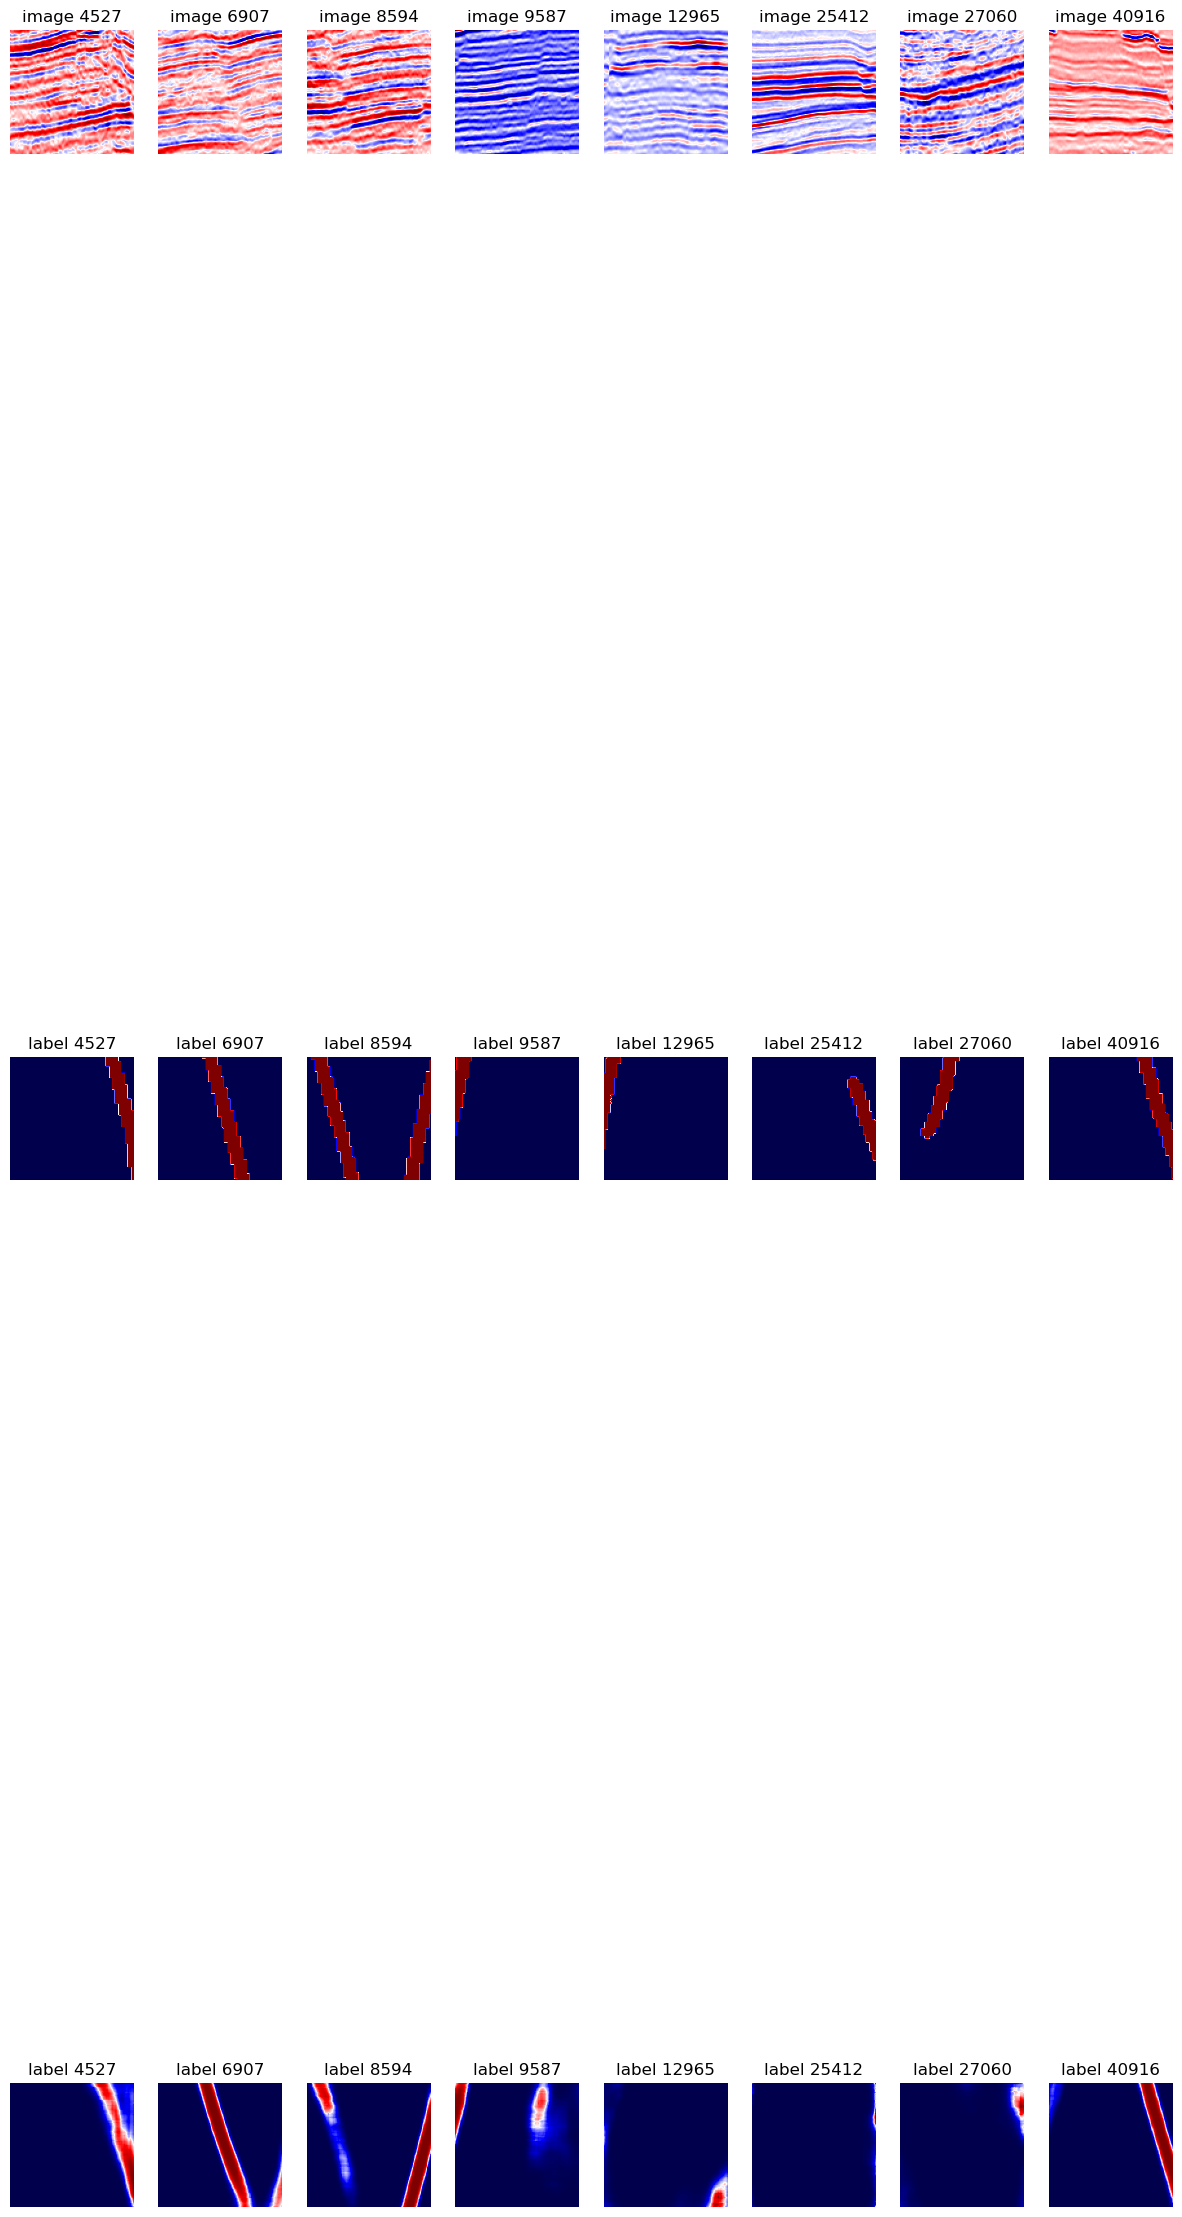

In [15]:

if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, y_pred)
    

In [16]:
model.evaluate(x=x_test)


   1/2065 [..............................] - ETA: 23:11 - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  29/2065 [..............................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan   

  58/2065 [..............................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  87/2065 [>.............................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 117/2065 [>.............................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 147/2065 [=>............................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 177/2065 [=>............................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 207/2065 [==>...........................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 236/2065 [==>...........................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 266/2065 [==>...........................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 296/2065 [===>..........................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 326/2065 [===>..........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 356/2065 [====>.........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 385/2065 [====>.........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 414/2065 [=====>........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 444/2065 [=====>........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 474/2065 [=====>........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 504/2065 [======>.......................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 534/2065 [======>.......................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 564/2065 [=======>......................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 594/2065 [=======>......................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 624/2065 [========>.....................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 653/2065 [========>.....................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 683/2065 [========>.....................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 713/2065 [=========>....................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 743/2065 [=========>....................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 772/2065 [==========>...................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 801/2065 [==========>...................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 830/2065 [===========>..................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 860/2065 [===========>..................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 889/2065 [===========>..................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 919/2065 [============>.................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 949/2065 [============>.................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 979/2065 [=============>................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1008/2065 [=============>................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1038/2065 [==============>...............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1067/2065 [==============>...............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1097/2065 [==============>...............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1127/2065 [===============>..............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1157/2065 [===============>..............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1186/2065 [================>.............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1216/2065 [================>.............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1245/2065 [=================>............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1275/2065 [=================>............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1304/2065 [=================>............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1333/2065 [==================>...........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1363/2065 [==================>...........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1393/2065 [===================>..........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1423/2065 [===================>..........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1453/2065 [====================>.........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1483/2065 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1513/2065 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1543/2065 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1573/2065 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1602/2065 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1631/2065 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1661/2065 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1691/2065 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1720/2065 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1750/2065 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1779/2065 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1809/2065 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1839/2065 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1869/2065 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1898/2065 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1928/2065 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1957/2065 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1986/2065 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

2016/2065 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

2046/2065 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

2065/2065 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan


[0.0, 0.0, nan]

In [17]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___24.25___minutes
                      0            1  accuracy     macro avg  weighted avg
precision  9.900000e-01         0.20       0.6  6.000000e-01  9.100000e-01
recall     5.500000e-01         0.96       0.6  7.600000e-01  6.000000e-01
f1-score   7.100000e-01         0.34       0.6  5.200000e-01  6.700000e-01
support    5.443481e+08  64617490.00       0.6  6.089656e+08  6.089656e+08
{'Avg-precision': 0.65, 'f1-score(ODS)': 0.34}
